**PIZA NAVA VLADIMIR**

**Laboratorio 7**

GithHub: https://github.com/vladi-13/Laboratorio7

Este código prepara el entorno para entrenar modelos en PyTorch, eligiendo entre DirectML, CUDA o CPU como dispositivo de cómputo, según lo que esté disponible. También importa librerías clave para procesamiento de imágenes, visualización y manejo de datos.


In [225]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import pandas as pd
from PIL import Image
from torchvision import transforms
import pickle

# Configurar dispositivo
try:
    import torch_directml
    device = torch_directml.device()
    print(f"Usando dispositivo DirectML: {device}")
except ImportError:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Usando dispositivo: {device}")

Usando dispositivo DirectML: privateuseone:0


Este código define una red neuronal llamada `DenseUNet`, que combina DenseNet121 como codificador (encoder) y bloques personalizados de decodificador (`SimpleDecoderBlock`) para realizar segmentación de imágenes. Usa conexiones tipo *skip* entre el encoder y el decoder para preservar detalles espaciales. La salida final es una predicción por píxel con `n_classes` clases.


In [226]:
class SimpleDecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(SimpleDecoderBlock, self).__init__()
        
        # Upsampling
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        # Convoluciones después de concatenar
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x, skip):
        # Upsample
        x = self.up(x)
        
        # Ajustar tamaños para la concatenación
        if x.size()[2:] != skip.size()[2:]:
            x = F.interpolate(x, size=skip.size()[2:], mode='bilinear', align_corners=True)
        
        # Concatenar con skip connection
        x = torch.cat([x, skip], dim=1)
        
        # Aplicar convolucion
        x = self.conv(x)
        
        return x

class DenseUNet(nn.Module):
    def __init__(self, n_classes=5, pretrained=True):
        super(DenseUNet, self).__init__()
        
        # Cargar DenseNet121 como encoder
        densenet = models.densenet121(pretrained=pretrained)
        
        # Extraer capas de DenseNet121
        self.first_conv = densenet.features.conv0
        self.first_bn = densenet.features.norm0
        self.first_relu = densenet.features.relu0
        self.first_pool = densenet.features.pool0
        
        self.encoder1 = densenet.features.denseblock1
        self.trans1 = densenet.features.transition1
        
        self.encoder2 = densenet.features.denseblock2
        self.trans2 = densenet.features.transition2
        
        self.encoder3 = densenet.features.denseblock3
        self.trans3 = densenet.features.transition3
        
        self.encoder4 = densenet.features.denseblock4
        
        # Canales en diferentes etapas del encoder - valores exactos para DenseNet121
        skip1_channels = 64    # Después de first_conv
        skip2_channels = 256   # Después de encoder1
        skip3_channels = 512   # Después de encoder2
        skip4_channels = 1024  # Después de encoder3
        bottleneck_channels = 1024  # Después de encoder4
        
        # Decoder con canales específicos para cada bloque
        self.decoder1 = SimpleDecoderBlock(bottleneck_channels, skip4_channels, 512)
        self.decoder2 = SimpleDecoderBlock(512, skip3_channels, 256)
        self.decoder3 = SimpleDecoderBlock(256, skip2_channels, 128)
        self.decoder4 = SimpleDecoderBlock(128, skip1_channels, 64)
        
        # Capa final
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
    
    def forward(self, x):
        # Guardar tamaño de entrada para resize final
        input_size = x.size()
        
        # Encoder path
        x = self.first_conv(x)    # 64 canales
        x = self.first_bn(x)
        x = self.first_relu(x)
        skip1 = x                 # 64 canales
        x = self.first_pool(x)
        
        x = self.encoder1(x)      # 256 canales
        skip2 = x
        x = self.trans1(x)
        
        x = self.encoder2(x)      # 512 canales
        skip3 = x
        x = self.trans2(x)
        
        x = self.encoder3(x)      # 1024 canales
        skip4 = x
        x = self.trans3(x)
        
        x = self.encoder4(x)      # 1024 canales
        
        # Decoder path con skip connections
        x = self.decoder1(x, skip4)
        x = self.decoder2(x, skip3)
        x = self.decoder3(x, skip2)
        x = self.decoder4(x, skip1)
        
        # Capa final
        x = self.final_conv(x)
        
        # Redimensionar a tamaño de entrada original
        if x.size()[2:] != input_size[2:]:
            x = F.interpolate(x, size=input_size[2:], mode='bilinear', align_corners=True)
        
        return x

Este código define un dataset personalizado llamado `FlowersDataset` que carga imágenes de flores clasificadas en cinco categorías. Lee las imágenes desde carpetas organizadas por clase, aplica transformaciones (como redimensionamiento, normalización y aumentos de datos), y retorna cada imagen junto con una máscara one-hot indicando su clase. También incluye una función `get_transforms` para crear transformaciones específicas para entrenamiento y prueba.


In [227]:
class FlowersDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, transform=None, img_size=128):
        self.base_dir = Path(base_dir)
        self.transform = transform
        self.img_size = img_size
        self.classes = ['astromelia', 'cartucho', 'lirio', 'obispo', 'sanjuan']
        
        # Recolectar rutas de imágenes
        self.images = []
        self.labels = []
        
        # Para cada carpeta de clase
        for i, class_name in enumerate(self.classes):
            class_dir = self.base_dir / class_name
            if not class_dir.exists():
                continue
                
            for img_path in class_dir.glob('*.jpg'):
                try:
                    # Verificar que la imagen se pueda abrir
                    with Image.open(img_path) as img:
                        # Verificar que no sea una imagen corrupta
                        img.verify()
                    
                    self.images.append(img_path)
                    self.labels.append(i)
                except Exception as e:
                    print(f"Error al verificar imagen {img_path}: {e}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        try:
            # Obtener ruta de imagen y etiqueta
            img_path = self.images[idx]
            label = self.labels[idx]
            
            # Cargar imagen
            img = Image.open(img_path).convert('RGB')
            
            # Asegurar que la imagen tenga el tamaño correcto
            if img.size != (self.img_size, self.img_size):
                img = img.resize((self.img_size, self.img_size), Image.BICUBIC)
            
            # Aplicar transformaciones
            if self.transform:
                img = self.transform(img)
            else:
                # Transformación por defecto si no se proporciona
                transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
                img = transform(img)
            
            # Crear máscara one-hot (para segmentación por clase)
            mask = torch.zeros((len(self.classes), self.img_size, self.img_size), dtype=torch.float32)
            mask[label] = 1.0  # La máscara completa corresponde a la clase de la flor
            
            return img, mask
            
        except Exception as e:
            print(f"Error en __getitem__ con índice {idx}: {e}")
            # Devolver tensor vacío en caso de error
            img = torch.zeros((3, self.img_size, self.img_size), dtype=torch.float32)
            mask = torch.zeros((len(self.classes), self.img_size, self.img_size), dtype=torch.float32)
            return img, mask

# Crear transformaciones
def get_transforms(img_size=128):
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, test_transform

Este código define una función de métrica llamada IoU (Intersección sobre Unión) para evaluar segmentación y una función `fit` para entrenar un modelo de segmentación por varias épocas. Durante cada época, realiza fases de entrenamiento y validación usando `BCEWithLogitsLoss` y calcula el IoU para monitorear el desempeño. Guarda el mejor modelo basado en la métrica de validación y almacena un historial de métricas como pérdida e IoU por época.


In [228]:
# Función de métrica IoU
def iou(outputs, labels, threshold=0.5):
    # Aplicar sigmoid y convertir a binario
    outputs = (torch.sigmoid(outputs) > threshold).float()
    labels = (labels > threshold).float()
    
    SMOOTH = 1e-6
    
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    
    for i in range(N):
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = torch.logical_and(_out, _labs).float().sum((1, 2))
        union = torch.logical_or(_out, _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    
    return np.mean(ious)

# Función de entrenamiento
def fit(model, dataloader, epochs=10, lr=1e-4):
    # Optimizador y función de pérdida
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    
    # Mover modelo a dispositivo
    model.to(device)
    print(f"Modelo movido a dispositivo: {device}")
    
    # Historial de métricas
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    best_iou = 0.0
    
    for epoch in range(1, epochs+1):
        # Fase de entrenamiento
        model.train()
        train_loss, train_iou = [], []
        
        for imgs, masks in tqdm(dataloader['train'], desc=f"Epoch {epoch}/{epochs} - Training"):
            try:
                # Mover datos a dispositivo
                imgs, masks = imgs.to(device), masks.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(imgs)
                
                # Calcular pérdida
                loss = criterion(outputs, masks)
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                # Calcular métricas
                batch_iou = iou(outputs.detach(), masks)
                train_loss.append(loss.item())
                train_iou.append(batch_iou)
                
            except Exception as e:
                print(f"Error en lote de entrenamiento: {e}")
                continue
        
        # Guardar métricas de entrenamiento
        if train_loss:
            epoch_loss = np.mean(train_loss)
            epoch_iou = np.mean(train_iou)
            hist['loss'].append(epoch_loss)
            hist['iou'].append(epoch_iou)
            
            print(f"Epoch {epoch}/{epochs} - Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}")
        
        # Fase de validación
        model.eval()
        test_loss, test_iou = [], []
        
        with torch.no_grad():
            for imgs, masks in tqdm(dataloader['test'], desc=f"Epoch {epoch}/{epochs} - Testing"):
                try:
                    # Mover datos a dispositivo
                    imgs, masks = imgs.to(device), masks.to(device)
                    
                    # Forward pass
                    outputs = model(imgs)
                    
                    # Calcular pérdida
                    loss = criterion(outputs, masks)
                    
                    # Calcular métricas
                    batch_iou = iou(outputs, masks)
                    test_loss.append(loss.item())
                    test_iou.append(batch_iou)
                    
                except Exception as e:
                    print(f"Error en lote de prueba: {e}")
                    continue
        
        # Guardar métricas de validación
        if test_loss:
            epoch_test_loss = np.mean(test_loss)
            epoch_test_iou = np.mean(test_iou)
            hist['test_loss'].append(epoch_test_loss)
            hist['test_iou'].append(epoch_test_iou)
            
            print(f"Epoch {epoch}/{epochs} - Test Loss: {epoch_test_loss:.4f}, Test IoU: {epoch_test_iou:.4f}")
            
            # Guardar mejor modelo (mover a CPU primero para evitar problemas con DirectML)
            if epoch_test_iou > best_iou:
                best_iou = epoch_test_iou
                # Mover a CPU para guardar
                model.to('cpu')
                torch.save(model.state_dict(), 'best_model.pth')
                # Volver a mover al dispositivo original
                model.to(device)
                print(f"Guardado mejor modelo con IoU: {best_iou:.4f}")
    
    # Guardar modelo final en CPU
    model.to('cpu')
    torch.save(model.state_dict(), 'modelo_final.pth')
    
    return hist

La función ofrece una visualización muy completa (imagen original, ground truth, predicción, comparativa, overlay y métricas clave con leyendas automáticas), pero podrías simplificarla moviendo consistentemente tensores y modelo al mismo dispositivo para evitar conversiones continuas y extraer la lógica de cálculo de métricas en pequeñas funciones auxiliares, lo que mejoraría la legibilidad y reutilización del código.


In [247]:
def visualizar_segmentacion_detallada(modelo, dataset, num_samples=4):
    """
    Visualización detallada enfocada en mostrar claramente las segmentaciones y máscaras.
    Incluye múltiples representaciones de las segmentaciones para mejor análisis:
    - Imagen original
    - Máscara ground truth
    - Predicción del modelo
    - Vista comparativa con código de colores
    - Segmentación superpuesta en imagen original
    
    Args:
        modelo: Modelo DenseUNet entrenado
        dataset: Conjunto de datos para visualizar
        num_samples: Número de muestras a visualizar
    """
    try:
        print("Generando visualización detallada de segmentación y máscaras...")
        
        # Preparar modelo
        modelo.eval()
        modelo = modelo.to('cpu')
        
        # Configurar colores distintivos para las clases
        import matplotlib.colors as mcolors
        from matplotlib.colors import LinearSegmentedColormap
        
        # Cargar algunas muestras aleatorias
        loader = torch.utils.data.DataLoader(
            dataset, batch_size=num_samples, shuffle=True
        )
        imgs, masks = next(iter(loader))
        
        # Hacer predicciones
        with torch.no_grad():
            outputs = modelo(imgs)
            probs = torch.sigmoid(outputs)
            pred_masks = torch.argmax(probs, dim=1)
        
        # Intentar obtener nombres de clases
        try:
            if hasattr(dataset, 'dataset') and hasattr(dataset.dataset, 'classes'):
                classes = dataset.dataset.classes
            else:
                classes = [f"Clase {i}" for i in range(outputs.shape[1])]
        except:
            classes = [f"Clase {i}" for i in range(outputs.shape[1])]
        
        # Crear una paleta de colores vibrantes y fácilmente distinguibles
        # Excluir colores muy claros y muy cercanos al blanco para mejor visualización
        color_list = [
            '#1f77b4',  # Azul
            '#ff7f0e',  # Naranja
            '#2ca02c',  # Verde
            '#d62728',  # Rojo
            '#9467bd',  # Púrpura
            '#8c564b',  # Marrón
            '#e377c2',  # Rosa
            '#7f7f7f',  # Gris
            '#bcbd22',  # Oliva
            '#17becf'   # Turquesa
        ]
        
        # Asegurar que haya suficientes colores para todas las clases
        while len(color_list) < outputs.shape[1]:
            color_list.append(f'#{np.random.randint(0, 16777215):06x}')
        
        # Convertir colores a RGB
        class_colors = [mcolors.to_rgb(color) for color in color_list[:outputs.shape[1]]]
        
        # Crear figura con dos filas por muestra:
        # Fila 1: Imagen | Máscara GT | Predicción
        # Fila 2: Comparativa | Overlay en imagen | Leyenda + Métricas
        fig = plt.figure(figsize=(18, 8 * num_samples))
        
        # Crear un colormap personalizado para segmentación
        bg_color = [0, 0, 0]  # Negro para el fondo/background
        mask_colors = [bg_color] + class_colors
        mask_cmap = LinearSegmentedColormap.from_list('mask_cmap', mask_colors, N=len(mask_colors))
        
        # Función para generar máscaras coloreadas
        def generate_colored_mask(mask, colors):
            colored_mask = np.zeros((*mask.shape, 3))
            for i in range(len(colors)):
                colored_mask[mask == i] = colors[i]
            return colored_mask
        
        # Función para superponer máscara en imagen
        def overlay_mask(img, mask, colors, alpha=0.7):
            colored_mask = generate_colored_mask(mask, colors)
            # Crear imagen compuesta
            overlay = img.copy()
            for c in range(3):
                overlay[:,:,c] = img[:,:,c] * (1 - alpha * (mask > 0)) + colored_mask[:,:,c] * alpha * (mask > 0)
            return overlay
        
        # Para cada muestra
        for i in range(num_samples):
            # Desnormalizar imagen
            img = imgs[i].permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            
            # Obtener máscaras
            true_mask = torch.argmax(masks[i], dim=0).numpy()
            pred_mask = pred_masks[i].numpy()
            
            # Crear máscaras coloreadas
            true_colored = generate_colored_mask(true_mask, mask_colors)
            pred_colored = generate_colored_mask(pred_mask, mask_colors)
            
            # Crear overlay
            true_overlay = overlay_mask(img, true_mask, mask_colors)
            pred_overlay = overlay_mask(img, pred_mask, mask_colors)
            
            # Crear una máscara de comparación
            # 0: Fondo correcto (negro)
            # 1: Clase predicha correctamente (verde)
            # 2: Clase predicha incorrectamente (rojo)
            # 3: No detectada (clase real > 0, pero pred = 0) (azul)
            # 4: Falso positivo (clase real = 0, pero pred > 0) (amarillo)
            comp_mask = np.zeros_like(true_mask)
            # Ambos fondo
            comp_mask[(true_mask == 0) & (pred_mask == 0)] = 0
            # Ambos misma clase (no fondo)
            comp_mask[(true_mask > 0) & (pred_mask > 0) & (true_mask == pred_mask)] = 1
            # Diferentes clases (ambos no fondo)
            comp_mask[(true_mask > 0) & (pred_mask > 0) & (true_mask != pred_mask)] = 2
            # No detectada (debería ser clase pero se predijo fondo)
            comp_mask[(true_mask > 0) & (pred_mask == 0)] = 3
            # Falso positivo (es fondo pero se predijo clase)
            comp_mask[(true_mask == 0) & (pred_mask > 0)] = 4
            
            # Colormap para comparación
            comp_colors = [
                [0, 0, 0],        # Negro (fondo correcto)
                [0, 0.8, 0],      # Verde (clase correcta)
                [0.8, 0, 0],      # Rojo (clase incorrecta)
                [0, 0, 0.8],      # Azul (no detectada)
                [0.8, 0.8, 0]     # Amarillo (falso positivo)
            ]
            comp_colored = generate_colored_mask(comp_mask, comp_colors)
            
            # ----- PRIMERA FILA -----
            # 1. Imagen Original
            ax1 = plt.subplot(2*num_samples, 3, i*6 + 1)
            ax1.imshow(img)
            ax1.set_title('Imagen Original', fontsize=12, fontweight='bold')
            ax1.axis('off')
            
            # 2. Máscara Ground Truth
            ax2 = plt.subplot(2*num_samples, 3, i*6 + 2)
            ax2.imshow(true_colored)
            ax2.set_title('Máscara Ground Truth', fontsize=12, fontweight='bold')
            ax2.axis('off')
            
            # 3. Máscara Predicha
            ax3 = plt.subplot(2*num_samples, 3, i*6 + 3)
            ax3.imshow(pred_colored)
            ax3.set_title('Predicción', fontsize=12, fontweight='bold')
            ax3.axis('off')
            
            # ----- SEGUNDA FILA -----
            # 4. Comparativa
            ax4 = plt.subplot(2*num_samples, 3, i*6 + 4)
            ax4.imshow(comp_colored)
            ax4.set_title('Comparativa de Segmentación', fontsize=12, fontweight='bold')
            ax4.axis('off')
            
            # Añadir leyenda de comparación
            comp_legend_elements = [
                plt.Rectangle((0, 0), 1, 1, color=comp_colors[0], label='Fondo Correcto'),
                plt.Rectangle((0, 0), 1, 1, color=comp_colors[1], label='Clase Correcta'),
                plt.Rectangle((0, 0), 1, 1, color=comp_colors[2], label='Clase Incorrecta'),
                plt.Rectangle((0, 0), 1, 1, color=comp_colors[3], label='No Detectada'),
                plt.Rectangle((0, 0), 1, 1, color=comp_colors[4], label='Falso Positivo')
            ]
            ax4.legend(handles=comp_legend_elements, loc='lower center', 
                      bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=8)
            
            # 5. Overlay de predicción en imagen
            ax5 = plt.subplot(2*num_samples, 3, i*6 + 5)
            ax5.imshow(pred_overlay)
            ax5.set_title('Segmentación Superpuesta', fontsize=12, fontweight='bold')
            ax5.axis('off')
            
            # 6. Métricas y Leyenda de Clases
            ax6 = plt.subplot(2*num_samples, 3, i*6 + 6)
            ax6.axis('off')
            
            # Crear leyenda de clases
            class_legend_elements = []
            for j in range(len(mask_colors)):
                if j == 0:
                    class_legend_elements.append(
                        plt.Rectangle((0, 0), 1, 1, color=mask_colors[j], label='Fondo')
                    )
                else:
                    class_legend_elements.append(
                        plt.Rectangle((0, 0), 1, 1, color=mask_colors[j], 
                                     label=classes[j-1] if j-1 < len(classes) else f'Clase {j-1}')
                    )
            
            # Añadir leyenda de clases
            ax6.legend(handles=class_legend_elements, loc='center', fontsize=10, 
                      title="Clases", title_fontsize=12)
            
            # Calcular métricas
            pixel_acc = np.mean(true_mask == pred_mask) * 100
            
            # IoU por clase
            class_ious = []
            for j in range(len(classes)):
                true_cls = (true_mask == j+1)  # +1 porque 0 es fondo
                pred_cls = (pred_mask == j+1)
                intersection = np.logical_and(true_cls, pred_cls).sum()
                union = np.logical_or(true_cls, pred_cls).sum()
                iou = intersection / (union + 1e-10)
                class_ious.append(iou)
            
            mean_iou = np.mean(class_ious)
            
            # Añadir texto con métricas
            metrics_text = (
                f"Precisión de Píxeles: {pixel_acc:.1f}%\n"
                f"IoU Promedio: {mean_iou:.3f}\n\n"
                f"Estadísticas de Predicción:\n"
                f"- Correctas: {np.sum(comp_mask <= 1) / comp_mask.size * 100:.1f}%\n"
                f"- Incorrectas: {np.sum(comp_mask > 1) / comp_mask.size * 100:.1f}%\n"
                f"  * Clase Errónea: {np.sum(comp_mask == 2) / comp_mask.size * 100:.1f}%\n"
                f"  * No Detectada: {np.sum(comp_mask == 3) / comp_mask.size * 100:.1f}%\n"
                f"  * Falso Positivo: {np.sum(comp_mask == 4) / comp_mask.size * 100:.1f}%"
            )
            
            # Añadir caja de texto con métricas
            ax6.text(0.5, 0.4, metrics_text, transform=ax6.transAxes, fontsize=10,
                   verticalalignment='top', horizontalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        plt.tight_layout()
        plt.savefig('segmentacion_detallada.png', dpi=200)
        plt.show()
        
        print("Visualización detallada de segmentación completada exitosamente.")
        
    except Exception as e:
        print(f"Error en visualización detallada: {e}")
        import traceback
        traceback.print_exc()

La función `main` organiza de forma clara todo el proceso de entrenamiento: define parámetros clave, aplica transformaciones, prepara el dataset y dataloaders, crea y entrena el modelo DenseNet121-UNet, y guarda tanto el historial como información útil del dataset, aunque podría simplificarse dividiendo responsabilidades (como carga de datos, inicialización del modelo y guardado) en funciones auxiliares para mejorar la modularidad y la legibilidad.


In [232]:
def main():
    try:
        print("Iniciando entrenamiento de DenseNet121-UNet...")
        
        # Parámetros
        IMG_SIZE = 128  # Tamaño de imagen
        BATCH_SIZE = 32  # Batch size pequeño
        NUM_CLASSES = 5  # astromelia, cartucho, lirio, obispo, sanjuan
        EPOCHS = 20     # Aumentamos épocas para mejor entrenamiento
        
        # Transformaciones
        train_transform, test_transform = get_transforms(IMG_SIZE)
        
        # Cargar dataset
        dataset_path = Path('./Dataset-Flores')
        if not dataset_path.exists():
            print("Dataset no encontrado en la ruta especificada.")
            dataset_path = Path('.')  # Intentar directorio actual
        
        # Crear dataset
        full_dataset = FlowersDataset(
            dataset_path, 
            transform=train_transform,
            img_size=IMG_SIZE
        )
        
        # Verificar si hay imágenes
        if len(full_dataset) == 0:
            raise ValueError("No se encontraron imágenes válidas en el conjunto de datos")
        
        print(f"Total de imágenes encontradas: {len(full_dataset)}")
        
        # División train/test (80% train, 20% test)
        train_size = int(0.8 * len(full_dataset))
        test_size = len(full_dataset) - train_size
        
        # Usar generator para reproducibilidad
        generator = torch.Generator().manual_seed(42)
        train_dataset, test_dataset = torch.utils.data.random_split(
            full_dataset, [train_size, test_size], generator=generator
        )
        
        print(f"Muestras de entrenamiento: {len(train_dataset)}")
        print(f"Muestras de prueba: {len(test_dataset)}")
        
        # Dataloaders
        dataloader = {
            'train': torch.utils.data.DataLoader(
                train_dataset, batch_size=BATCH_SIZE, 
                shuffle=True, num_workers=0,
                pin_memory=False, drop_last=True
            ),
            'test': torch.utils.data.DataLoader(
                test_dataset, batch_size=BATCH_SIZE, 
                shuffle=False, num_workers=0,
                pin_memory=False, drop_last=True
            )
        }
        
        # Crear modelo
        model = DenseUNet(n_classes=NUM_CLASSES, pretrained=True)
        print("Modelo DenseNet121-UNet inicializado correctamente.")
        
        # Mostrar resumen del modelo
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total de parámetros del modelo: {total_params:,}")
        
        # Entrenar modelo
        print("Iniciando entrenamiento...")
        history = fit(model, dataloader, epochs=EPOCHS, lr=1e-4)
        
        # Guardar historial para uso posterior
        with open('historial_entrenamiento.pkl', 'wb') as f:
            pickle.dump(history, f)
        
        print("Entrenamiento completado. Historial guardado en 'historial_entrenamiento.pkl'")
        
        # Guardar información del dataset
        with open('dataset_info.pkl', 'wb') as f:
            dataset_info = {
                'train_size': len(train_dataset),
                'test_size': len(test_dataset),
                'img_size': IMG_SIZE,
                'num_classes': NUM_CLASSES,
                'test_dataset': test_dataset
            }
            pickle.dump(dataset_info, f)
        
        # Mover modelo a CPU
        model = model.to('cpu')
        
        return model, train_dataset, test_dataset, history
        
    except Exception as e:
        print(f"Error en el entrenamiento: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

# Si quieres ejecutar el entrenamiento directamente
if __name__ == "__main__":
    modelo, train_dataset, test_dataset, history = main()

Iniciando entrenamiento de DenseNet121-UNet...
Total de imágenes encontradas: 2000
Muestras de entrenamiento: 1600
Muestras de prueba: 400
Modelo DenseNet121-UNet inicializado correctamente.
Total de parámetros del modelo: 25,721,669
Iniciando entrenamiento...
Modelo movido a dispositivo: privateuseone:0


Epoch 1/20 - Training: 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


Epoch 1/20 - Train Loss: 0.7246, Train IoU: 0.1068


Epoch 1/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


Epoch 1/20 - Test Loss: 0.7568, Test IoU: 0.1362
Guardado mejor modelo con IoU: 0.1362


Epoch 2/20 - Training: 100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


Epoch 2/20 - Train Loss: 0.7245, Train IoU: 0.1069


Epoch 2/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch 2/20 - Test Loss: 0.7269, Test IoU: 0.1045


Epoch 3/20 - Training: 100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


Epoch 3/20 - Train Loss: 0.7244, Train IoU: 0.1069


Epoch 3/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


Epoch 3/20 - Test Loss: 0.7264, Test IoU: 0.1048


Epoch 4/20 - Training: 100%|██████████| 50/50 [00:51<00:00,  1.04s/it]


Epoch 4/20 - Train Loss: 0.7247, Train IoU: 0.1064


Epoch 4/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Epoch 4/20 - Test Loss: 0.7281, Test IoU: 0.1033


Epoch 5/20 - Training: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


Epoch 5/20 - Train Loss: 0.7246, Train IoU: 0.1066


Epoch 5/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch 5/20 - Test Loss: 0.7275, Test IoU: 0.1028


Epoch 6/20 - Training: 100%|██████████| 50/50 [01:04<00:00,  1.28s/it]


Epoch 6/20 - Train Loss: 0.7251, Train IoU: 0.1063


Epoch 6/20 - Testing: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch 6/20 - Test Loss: 0.7276, Test IoU: 0.1027


Epoch 7/20 - Training: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


Epoch 7/20 - Train Loss: 0.7245, Train IoU: 0.1070


Epoch 7/20 - Testing: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch 7/20 - Test Loss: 0.7270, Test IoU: 0.1052


Epoch 8/20 - Training: 100%|██████████| 50/50 [01:08<00:00,  1.38s/it]


Epoch 8/20 - Train Loss: 0.7251, Train IoU: 0.1064


Epoch 8/20 - Testing: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch 8/20 - Test Loss: 0.7274, Test IoU: 0.1020


Epoch 9/20 - Training: 100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


Epoch 9/20 - Train Loss: 0.7242, Train IoU: 0.1071


Epoch 9/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]


Epoch 9/20 - Test Loss: 0.7264, Test IoU: 0.1031


Epoch 10/20 - Training: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


Epoch 10/20 - Train Loss: 0.7252, Train IoU: 0.1062


Epoch 10/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch 10/20 - Test Loss: 0.7277, Test IoU: 0.1027


Epoch 11/20 - Training: 100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


Epoch 11/20 - Train Loss: 0.7250, Train IoU: 0.1064


Epoch 11/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch 11/20 - Test Loss: 0.7295, Test IoU: 0.1024


Epoch 12/20 - Training: 100%|██████████| 50/50 [01:09<00:00,  1.38s/it]


Epoch 12/20 - Train Loss: 0.7247, Train IoU: 0.1065


Epoch 12/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]


Epoch 12/20 - Test Loss: 0.7292, Test IoU: 0.1019


Epoch 13/20 - Training: 100%|██████████| 50/50 [01:09<00:00,  1.38s/it]


Epoch 13/20 - Train Loss: 0.7249, Train IoU: 0.1067


Epoch 13/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch 13/20 - Test Loss: 0.7267, Test IoU: 0.1036


Epoch 14/20 - Training: 100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


Epoch 14/20 - Train Loss: 0.7251, Train IoU: 0.1065


Epoch 14/20 - Testing: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch 14/20 - Test Loss: 0.7267, Test IoU: 0.1043


Epoch 15/20 - Training: 100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


Epoch 15/20 - Train Loss: 0.7245, Train IoU: 0.1068


Epoch 15/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Epoch 15/20 - Test Loss: 0.7284, Test IoU: 0.1031


Epoch 16/20 - Training: 100%|██████████| 50/50 [01:07<00:00,  1.36s/it]


Epoch 16/20 - Train Loss: 0.7246, Train IoU: 0.1067


Epoch 16/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch 16/20 - Test Loss: 0.7282, Test IoU: 0.1036


Epoch 17/20 - Training: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


Epoch 17/20 - Train Loss: 0.7252, Train IoU: 0.1063


Epoch 17/20 - Testing: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch 17/20 - Test Loss: 0.7265, Test IoU: 0.1028


Epoch 18/20 - Training: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


Epoch 18/20 - Train Loss: 0.7251, Train IoU: 0.1063


Epoch 18/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Epoch 18/20 - Test Loss: 0.7289, Test IoU: 0.1026


Epoch 19/20 - Training: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


Epoch 19/20 - Train Loss: 0.7250, Train IoU: 0.1066


Epoch 19/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch 19/20 - Test Loss: 0.7284, Test IoU: 0.1036


Epoch 20/20 - Training: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


Epoch 20/20 - Train Loss: 0.7247, Train IoU: 0.1066


Epoch 20/20 - Testing: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch 20/20 - Test Loss: 0.7262, Test IoU: 0.1038
Entrenamiento completado. Historial guardado en 'historial_entrenamiento.pkl'


La función `ejecutar_visualizacion_detallada` intenta cargar un modelo previamente entrenado y su dataset de prueba para generar visualizaciones de segmentación, manejando fallos en la carga de archivos con una recreación del dataset si es necesario, aunque podría beneficiarse de una mejor separación de responsabilidades y menor redundancia para mayor claridad y mantenibilidad.


Iniciando visualización detallada de segmentación...
Dataset cargado con 400 muestras de prueba


C:\Users\vladi\AppData\Local\Temp\ipykernel_27840\1444281076.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo.load_state_dict(torch.load('best_model.pth', map_loc

Modelo cargado desde 'best_model.pth'
Generando visualización detallada de segmentación y máscaras...


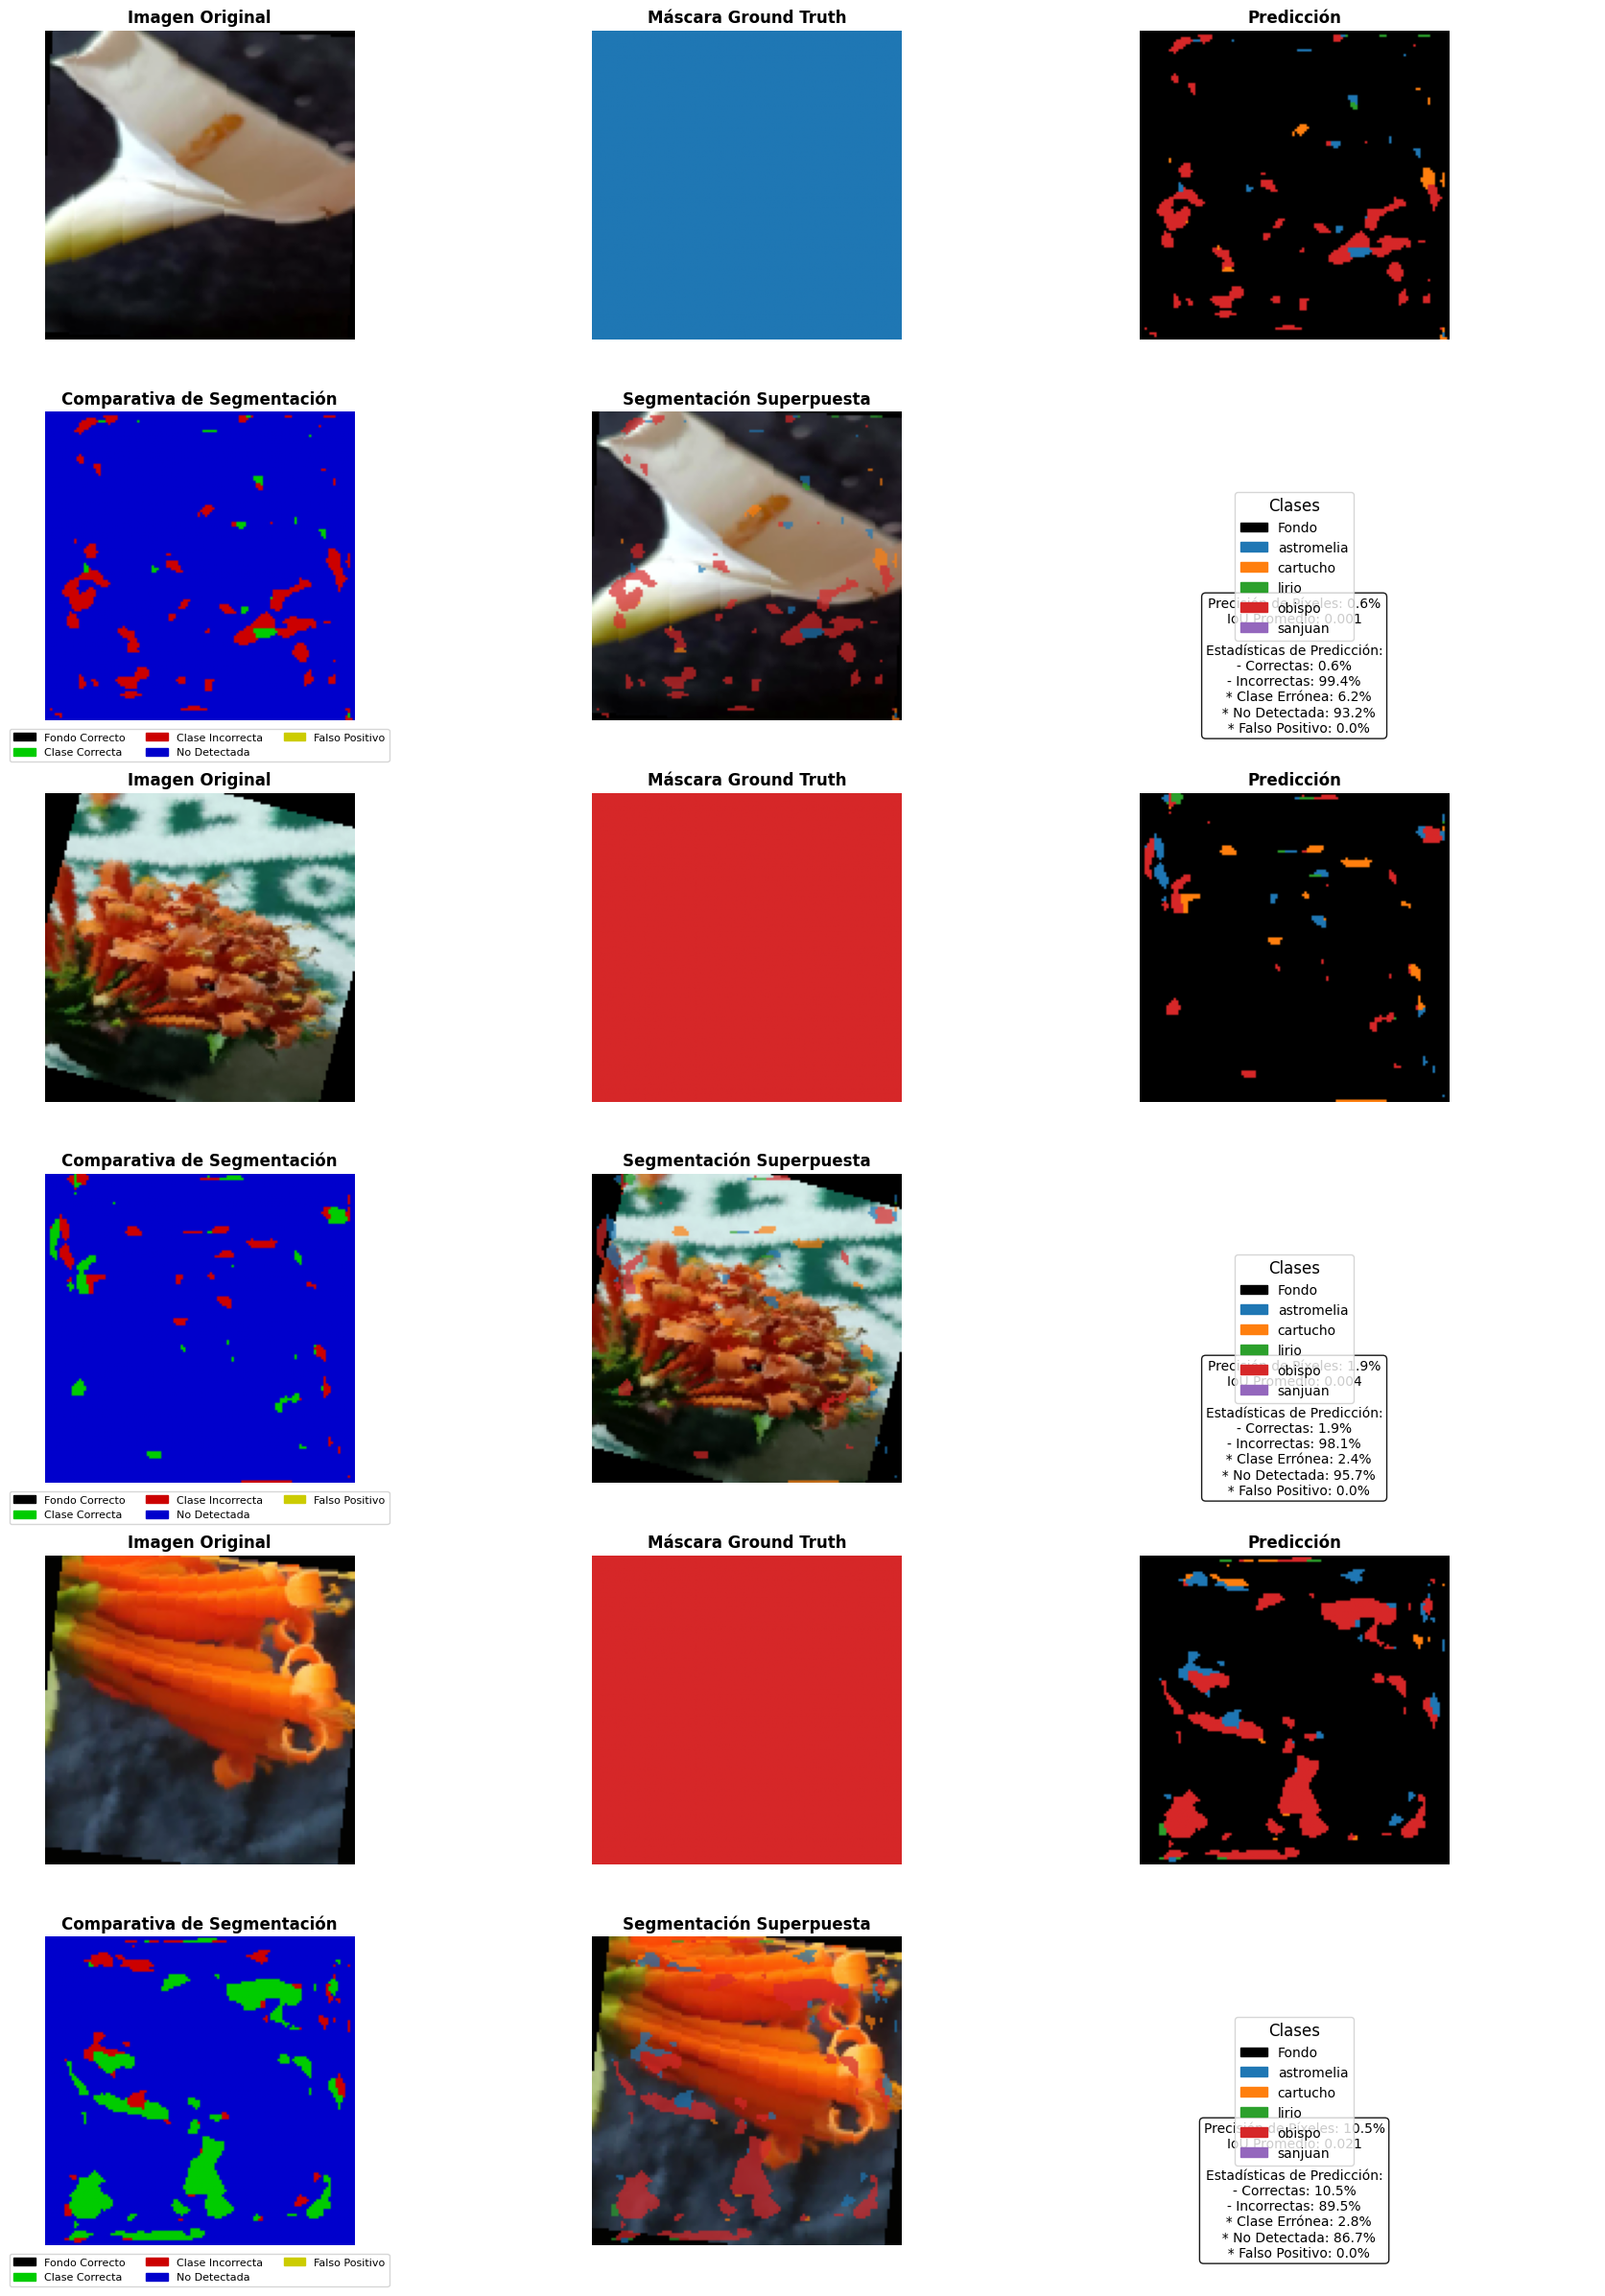

Visualización detallada de segmentación completada exitosamente.


In [248]:
def ejecutar_visualizacion_detallada():
    """
    Carga un modelo entrenado y genera una visualización detallada de segmentación y máscaras.
    """
    try:
        print("Iniciando visualización detallada de segmentación...")
        
        # Cargar dataset
        try:
            with open('dataset_info.pkl', 'rb') as f:
                dataset_info = pickle.load(f)
                test_dataset = dataset_info['test_dataset']
                NUM_CLASSES = dataset_info['num_classes']
                print(f"Dataset cargado con {len(test_dataset)} muestras de prueba")
        except:
            print("No se pudo cargar dataset_info.pkl. Recreando dataset...")
            
            # Recrear dataset
            IMG_SIZE = 128
            NUM_CLASSES = 5
            dataset_path = Path('./Dataset-Flores')
            if not dataset_path.exists():
                dataset_path = Path('.')
            
            _, test_transform = get_transforms(IMG_SIZE)
            
            full_dataset = FlowersDataset(
                dataset_path, 
                transform=test_transform,
                img_size=IMG_SIZE
            )
            
            if len(full_dataset) == 0:
                raise ValueError("No se encontraron imágenes válidas en el conjunto de datos")
            
            train_size = int(0.8 * len(full_dataset))
            test_size = len(full_dataset) - train_size
            
            generator = torch.Generator().manual_seed(42)
            _, test_dataset = torch.utils.data.random_split(
                full_dataset, [train_size, test_size], generator=generator
            )
            
            NUM_CLASSES = 5
            print(f"Dataset recreado con {len(test_dataset)} muestras de prueba")
        
        # Cargar modelo entrenado
        modelo = DenseUNet(n_classes=NUM_CLASSES, pretrained=False)
        
        # Intentar cargar pesos del mejor modelo
        try:
            modelo.load_state_dict(torch.load('best_model.pth', map_location='cpu'))
            print("Modelo cargado desde 'best_model.pth'")
        except Exception as e1:
            print(f"No se pudo cargar best_model.pth: {e1}")
            try:
                modelo.load_state_dict(torch.load('modelo_final.pth', map_location='cpu'))
                print("Modelo cargado desde 'modelo_final.pth'")
            except Exception as e2:
                print(f"No se pudo cargar modelo_final.pth: {e2}")
                print("ADVERTENCIA: Se usará un modelo sin entrenar para la visualización.")
        
        # Generar visualización detallada
        visualizar_segmentacion_detallada(modelo, test_dataset, num_samples=3)
        
    except Exception as e:
        print(f"Error al ejecutar visualización detallada: {e}")
        import traceback
        traceback.print_exc()

# Ejecutar visualización detallada
ejecutar_visualizacion_detallada()

La función `transfer_learning_densenet_unet` realiza un entrenamiento de transfer learning usando DenseNet121 como encoder, congelando sus capas y entrenando solo el decoder. Utiliza Early Stopping para evitar el sobreajuste, guardando el mejor modelo según la pérdida de validación. Durante el proceso, calcula las métricas de pérdida e IoU, las cuales se almacenan para su análisis.


In [257]:
def transfer_learning_densenet_unet(train_dataset, val_dataset, num_classes=5, epochs=10, patience=3):
    """
    Realiza transfer learning usando DenseNet121 preentrenado como encoder.
    Congela las capas del encoder y solo entrena el decoder.
    
    Args:
        train_dataset: Dataset de entrenamiento
        val_dataset: Dataset de validación
        num_classes: Número de clases para segmentación
        epochs: Número máximo de épocas
        patience: Número de épocas para early stopping
    
    Returns:
        Modelo entrenado
    """
    try:
        print("Iniciando Transfer Learning para DenseNet-UNet...")
        
        # Crear dataloaders
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=32, shuffle=True, 
            num_workers=0, pin_memory=False, drop_last=True
        )
        
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=32, shuffle=False,
            num_workers=0, pin_memory=False, drop_last=True
        )
        
        # Crear modelo con DenseNet121 preentrenado
        model = DenseUNet(n_classes=num_classes, pretrained=True)
        
        # Congelar las capas del encoder (DenseNet)
        # Esto incluye first_conv, encoders y transiciones
        encoder_layers = [
            model.first_conv, model.first_bn, model.first_relu, model.first_pool,
            model.encoder1, model.trans1,
            model.encoder2, model.trans2,
            model.encoder3, model.trans3,
            model.encoder4
        ]
        
        # Congelar todos los parámetros del encoder
        for layer in encoder_layers:
            for param in layer.parameters():
                param.requires_grad = False
        
        # Verificar número de parámetros entrenables vs. congelados
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        frozen_params = total_params - trainable_params
        
        print(f"Total de parámetros: {total_params:,}")
        print(f"Parámetros congelados: {frozen_params:,} ({frozen_params/total_params*100:.1f}%)")
        print(f"Parámetros entrenables: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
        
        # Mover modelo a dispositivo
        model.to(device)
        print(f"Modelo movido a dispositivo: {device}")
        
        # Optimizador (solo para parámetros entrenables) y función de pérdida
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=1e-4,
            weight_decay=1e-5
        )
        criterion = nn.BCEWithLogitsLoss()
        
        # Configuración para Early Stopping
        best_val_loss = float('inf')
        early_stop_counter = 0
        history = {'train_loss': [], 'train_iou': [], 'val_loss': [], 'val_iou': []}
        
        for epoch in range(1, epochs+1):
            # ---- Fase de Entrenamiento ----
            model.train()
            train_loss, train_iou = [], []
            
            # Barra de progreso para entrenamiento
            train_loader_tqdm = tqdm(train_loader, desc=f"Época {epoch}/{epochs} [Transfer Learning]", leave=False)
            
            for imgs, masks in train_loader_tqdm:
                try:
                    # Mover datos a dispositivo
                    imgs, masks = imgs.to(device), masks.to(device)
                    
                    # Forward pass
                    optimizer.zero_grad()
                    outputs = model(imgs)
                    
                    # Calcular pérdida
                    loss = criterion(outputs, masks)
                    
                    # Backward pass
                    loss.backward()
                    optimizer.step()
                    
                    # Calcular métricas
                    batch_iou = iou(outputs.detach(), masks)
                    train_loss.append(loss.item())
                    train_iou.append(batch_iou)
                    
                    # Actualizar barra de progreso
                    train_loader_tqdm.set_postfix(loss=f"{loss.item():.4f}", iou=f"{batch_iou:.4f}")
                    
                except Exception as e:
                    print(f"Error en lote de entrenamiento: {e}")
                    continue
            
            # Calcular métricas promedio de entrenamiento
            if train_loss:
                epoch_train_loss = np.mean(train_loss)
                epoch_train_iou = np.mean(train_iou)
                history['train_loss'].append(epoch_train_loss)
                history['train_iou'].append(epoch_train_iou)
            else:
                epoch_train_loss = float('nan')
                epoch_train_iou = float('nan')
            
            # ---- Fase de Validación ----
            model.eval()
            val_loss, val_iou = [], []
            
            with torch.no_grad():
                for imgs, masks in tqdm(val_loader, desc=f"Validación {epoch}/{epochs}", leave=False):
                    try:
                        # Mover datos a dispositivo
                        imgs, masks = imgs.to(device), masks.to(device)
                        
                        # Forward pass
                        outputs = model(imgs)
                        
                        # Calcular pérdida
                        loss = criterion(outputs, masks)
                        
                        # Calcular métricas
                        batch_iou = iou(outputs, masks)
                        val_loss.append(loss.item())
                        val_iou.append(batch_iou)
                        
                    except Exception as e:
                        print(f"Error en lote de validación: {e}")
                        continue
            
            # Calcular métricas promedio de validación
            if val_loss:
                epoch_val_loss = np.mean(val_loss)
                epoch_val_iou = np.mean(val_iou)
                history['val_loss'].append(epoch_val_loss)
                history['val_iou'].append(epoch_val_iou)
            else:
                epoch_val_loss = float('nan')
                epoch_val_iou = float('nan')
            
            # Imprimir resultados de la época
            print(f"\nÉpoca {epoch}/{epochs} - Transfer Learning")
            print(f"  Train Loss: {epoch_train_loss:.4f} | Train IoU: {epoch_train_iou:.4f}")
            print(f"  Val Loss: {epoch_val_loss:.4f} | Val IoU: {epoch_val_iou:.4f}")
            
            # Verificar Early Stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                early_stop_counter = 0
                
                # Guardar mejor modelo (en CPU)
                model.to('cpu')
                torch.save(model.state_dict(), 'best_model_transfer.pth')
                model.to(device)
                
                print(f"  🔥 Nuevo mejor modelo guardado! (Transfer Learning)")
            else:
                early_stop_counter += 1
                print(f"  ⏳ Early Stopping Counter: {early_stop_counter}/{patience}")
            
            # Detener entrenamiento si se cumple early stopping
            if early_stop_counter >= patience:
                print("\n🚨 Deteniendo entrenamiento por Early Stopping 🚨")
                break
        
        # Cargar el mejor modelo para retornarlo
        model.to('cpu')
        model.load_state_dict(torch.load('best_model_transfer.pth'))
        
        # Guardar historial de entrenamiento
        with open('historial_transfer_learning.pkl', 'wb') as f:
            pickle.dump(history, f)
        
        print("Transfer Learning completado. Historial guardado en 'historial_transfer_learning.pkl'")
        
        return model, history
        
    except Exception as e:
        print(f"Error en transfer learning: {e}")
        import traceback
        traceback.print_exc()
        return None, None

La función `fine_tuning_densenet_unet` realiza el fine-tuning de un modelo DenseNet-UNet completo, comenzando con un modelo preentrenado (usualmente desde transfer learning). Descongela todas las capas para hacerlas entrenables y aplica un optimizador con una tasa de aprendizaje más baja para afinar los pesos. Usa Early Stopping para evitar el sobreajuste y guarda el mejor modelo basado en la pérdida de validación. Durante el proceso, se calculan métricas de pérdida e IoU, y se ajusta la tasa de aprendizaje con un scheduler.


In [259]:
def fine_tuning_densenet_unet(train_dataset, val_dataset, num_classes=5, epochs=5, patience=2, 
                             pretrained_path='best_model_transfer.pth'):
    """
    Realiza fine-tuning del modelo DenseNet-UNet completo después del transfer learning.
    Descongela todas las capas y entrena con una tasa de aprendizaje más baja.
    
    Args:
        train_dataset: Dataset de entrenamiento
        val_dataset: Dataset de validación
        num_classes: Número de clases para segmentación
        epochs: Número máximo de épocas
        patience: Número de épocas para early stopping
        pretrained_path: Ruta al modelo preentrenado con transfer learning
    
    Returns:
        Modelo entrenado con fine-tuning
    """
    try:
        print("Iniciando Fine-Tuning para DenseNet-UNet...")
        
        # Crear dataloaders
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=32, shuffle=True, 
            num_workers=0, pin_memory=False, drop_last=True
        )
        
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=32, shuffle=False,
            num_workers=0, pin_memory=False, drop_last=True
        )
        
        # Crear modelo
        model = DenseUNet(n_classes=num_classes, pretrained=False)
        
        # Cargar pesos del modelo entrenado con transfer learning
        try:
            model.load_state_dict(torch.load(pretrained_path))
            print(f"Modelo cargado desde {pretrained_path}")
        except Exception as e:
            print(f"No se pudo cargar el modelo preentrenado: {e}")
            print("Iniciando fine-tuning desde un modelo con encoder preentrenado")
            model = DenseUNet(n_classes=num_classes, pretrained=True)
        
        # Descongelar todas las capas - Ahora todas son entrenables
        for param in model.parameters():
            param.requires_grad = True
        
        # Verificar número de parámetros entrenables
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        print(f"Total de parámetros: {total_params:,}")
        print(f"Parámetros entrenables: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
        
        # Mover modelo a dispositivo
        model.to(device)
        print(f"Modelo movido a dispositivo: {device}")
        
        # Optimizador con tasa de aprendizaje más baja
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=1e-5,  # Tasa de aprendizaje más baja para fine-tuning
            weight_decay=1e-6
        )
        
        # Scheduler para reducir tasa de aprendizaje al estancarse
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=2, verbose=True
        )
        
        criterion = nn.BCEWithLogitsLoss()
        
        # Configuración para Early Stopping
        best_val_loss = float('inf')
        early_stop_counter = 0
        history = {'train_loss': [], 'train_iou': [], 'val_loss': [], 'val_iou': []}
        
        for epoch in range(1, epochs+1):
            # ---- Fase de Entrenamiento ----
            model.train()
            train_loss, train_iou = [], []
            
            # Barra de progreso para entrenamiento
            train_loader_tqdm = tqdm(train_loader, desc=f"Época {epoch}/{epochs} [Fine-Tuning]", leave=False)
            
            for imgs, masks in train_loader_tqdm:
                try:
                    # Mover datos a dispositivo
                    imgs, masks = imgs.to(device), masks.to(device)
                    
                    # Forward pass
                    optimizer.zero_grad()
                    outputs = model(imgs)
                    
                    # Calcular pérdida
                    loss = criterion(outputs, masks)
                    
                    # Backward pass
                    loss.backward()
                    optimizer.step()
                    
                    # Calcular métricas
                    batch_iou = iou(outputs.detach(), masks)
                    train_loss.append(loss.item())
                    train_iou.append(batch_iou)
                    
                    # Actualizar barra de progreso
                    train_loader_tqdm.set_postfix(loss=f"{loss.item():.4f}", iou=f"{batch_iou:.4f}")
                    
                except Exception as e:
                    print(f"Error en lote de entrenamiento: {e}")
                    continue
            
            # Calcular métricas promedio de entrenamiento
            if train_loss:
                epoch_train_loss = np.mean(train_loss)
                epoch_train_iou = np.mean(train_iou)
                history['train_loss'].append(epoch_train_loss)
                history['train_iou'].append(epoch_train_iou)
            else:
                epoch_train_loss = float('nan')
                epoch_train_iou = float('nan')
            
            # ---- Fase de Validación ----
            model.eval()
            val_loss, val_iou = [], []
            
            with torch.no_grad():
                for imgs, masks in tqdm(val_loader, desc=f"Validación {epoch}/{epochs}", leave=False):
                    try:
                        # Mover datos a dispositivo
                        imgs, masks = imgs.to(device), masks.to(device)
                        
                        # Forward pass
                        outputs = model(imgs)
                        
                        # Calcular pérdida
                        loss = criterion(outputs, masks)
                        
                        # Calcular métricas
                        batch_iou = iou(outputs, masks)
                        val_loss.append(loss.item())
                        val_iou.append(batch_iou)
                        
                    except Exception as e:
                        print(f"Error en lote de validación: {e}")
                        continue
            
            # Calcular métricas promedio de validación
            if val_loss:
                epoch_val_loss = np.mean(val_loss)
                epoch_val_iou = np.mean(val_iou)
                history['val_loss'].append(epoch_val_loss)
                history['val_iou'].append(epoch_val_iou)
                
                # Actualizar scheduler
                scheduler.step(epoch_val_loss)
            else:
                epoch_val_loss = float('nan')
                epoch_val_iou = float('nan')
            
            # Imprimir resultados de la época
            print(f"\nÉpoca {epoch}/{epochs} - Fine-Tuning")
            print(f"  Train Loss: {epoch_train_loss:.4f} | Train IoU: {epoch_train_iou:.4f}")
            print(f"  Val Loss: {epoch_val_loss:.4f} | Val IoU: {epoch_val_iou:.4f}")
            print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
            
            # Verificar Early Stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                early_stop_counter = 0
                
                # Guardar mejor modelo (en CPU)
                model.to('cpu')
                torch.save(model.state_dict(), 'best_model_finetune.pth')
                model.to(device)
                
                print(f"  🔥 Nuevo mejor modelo guardado! (Fine-Tuning)")
            else:
                early_stop_counter += 1
                print(f"  ⏳ Early Stopping Counter: {early_stop_counter}/{patience}")
            
            # Detener entrenamiento si se cumple early stopping
            if early_stop_counter >= patience:
                print("\n🚨 Deteniendo entrenamiento por Early Stopping 🚨")
                break
        
        # Cargar el mejor modelo para retornarlo
        model.to('cpu')
        model.load_state_dict(torch.load('best_model_finetune.pth'))
        
        # Guardar historial de entrenamiento
        with open('historial_fine_tuning.pkl', 'wb') as f:
            pickle.dump(history, f)
        
        print("Fine-Tuning completado. Historial guardado en 'historial_fine_tuning.pkl'")
        
        return model, history
        
    except Exception as e:
        print(f"Error en fine-tuning: {e}")
        import traceback
        traceback.print_exc()
        return None, None

La función `entrenar_modelo_completo` entrena un modelo de segmentación de flores, comenzando con la preparación de datos, seguido de transfer learning y fine-tuning. Luego, evalúa el modelo en el conjunto de prueba, calcula el IoU y genera curvas de aprendizaje. Finalmente, guarda el mejor modelo y las métricas.


In [260]:
def entrenar_modelo_completo(dataset_path='./Dataset-Flores', img_size=128, num_classes=5):
    """
    Realiza el proceso completo de entrenamiento:
    1. Preparación de datos
    2. Transfer Learning (encoder congelado)
    3. Fine-Tuning (todo el modelo)
    4. Evaluación y visualización
    
    Args:
        dataset_path: Ruta al dataset de flores
        img_size: Tamaño de imagen
        num_classes: Número de clases (tipos de flores)
    
    Returns:
        Modelo final entrenado
    """
    try:
        print("=== INICIANDO ENTRENAMIENTO COMPLETO CON TRANSFER LEARNING Y FINE-TUNING ===")
        
        # 1. Preparación de datos
        print("\n1. Preparando datos...")
        
        # Transformaciones
        train_transform, test_transform = get_transforms(img_size)
        
        # Cargar dataset
        dataset_path = Path(dataset_path)
        if not dataset_path.exists():
            print("Dataset no encontrado en la ruta especificada.")
            dataset_path = Path('.')
        
        # Crear dataset
        full_dataset = FlowersDataset(
            dataset_path, 
            transform=train_transform,
            img_size=img_size
        )
        
        # Verificar si hay imágenes
        if len(full_dataset) == 0:
            raise ValueError("No se encontraron imágenes válidas en el conjunto de datos")
        
        print(f"Total de imágenes encontradas: {len(full_dataset)}")
        
        # División en train, val y test (70% train, 15% val, 15% test)
        train_size = int(0.7 * len(full_dataset))
        val_size = int(0.15 * len(full_dataset))
        test_size = len(full_dataset) - train_size - val_size
        
        # Usar generator para reproducibilidad
        generator = torch.Generator().manual_seed(42)
        train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
            full_dataset, [train_size, val_size, test_size], generator=generator
        )
        
        print(f"Muestras de entrenamiento: {len(train_dataset)}")
        print(f"Muestras de validación: {len(val_dataset)}")
        print(f"Muestras de prueba: {len(test_dataset)}")
        
        # 2. Transfer Learning - Solo entrenamos el decoder
        print("\n2. Entrenando con Transfer Learning (encoder congelado)...")
        model_transfer, history_transfer = transfer_learning_densenet_unet(
            train_dataset, val_dataset, num_classes=num_classes, epochs=10, patience=3
        )
        
        if model_transfer is None:
            raise ValueError("Error durante el transfer learning")
        
        # Guardar información para uso posterior
        with open('dataset_info.pkl', 'wb') as f:
            dataset_info = {
                'train_size': len(train_dataset),
                'val_size': len(val_dataset),
                'test_size': len(test_dataset),
                'img_size': img_size,
                'num_classes': num_classes,
                'test_dataset': test_dataset
            }
            pickle.dump(dataset_info, f)
        
        # 3. Fine-tuning - Entrenamos todo el modelo
        print("\n3. Realizando Fine-Tuning (modelo completo)...")
        model_finetune, history_finetune = fine_tuning_densenet_unet(
            train_dataset, val_dataset, num_classes=num_classes, epochs=5, patience=2,
            pretrained_path='best_model_transfer.pth'
        )
        
        if model_finetune is None:
            print("Error durante el fine-tuning, usando el modelo de transfer learning")
            model_finetune = model_transfer
        
        # 4. Evaluación final en conjunto de prueba
        print("\n4. Evaluación final en conjunto de prueba...")
        
        # Crear dataloader para test
        test_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=64, shuffle=False, 
            num_workers=0, pin_memory=False
        )
        
        # Evaluar modelo con métricas
        model_finetune.eval()
        test_iou_scores = []
        
        with torch.no_grad():
            for imgs, masks in tqdm(test_loader, desc="Evaluando modelo final"):
                try:
                    imgs, masks = imgs.to('cpu'), masks.to('cpu')
                    outputs = model_finetune(imgs)
                    batch_iou = iou(outputs, masks)
                    test_iou_scores.append(batch_iou)
                except Exception as e:
                    print(f"Error en evaluación: {e}")
                    continue
        
        mean_test_iou = np.mean(test_iou_scores) if test_iou_scores else float('nan')
        print(f"IoU en conjunto de prueba: {mean_test_iou:.4f}")
        
        # 5. Visualización de resultados
        print("\n5. Generando visualización de resultados...")
        visualizar_segmentacion_detallada(model_finetune, test_dataset, num_samples=3)
        
        # Graficar curvas de aprendizaje
        # Combinar historiales de transfer learning y fine-tuning
        plt.figure(figsize=(12, 5))
        
        # Curva de pérdida
        plt.subplot(1, 2, 1)
        plt.plot(history_transfer['train_loss'], 'b-', label='Transfer - Train')
        plt.plot(history_transfer['val_loss'], 'b--', label='Transfer - Val')
        
        # Añadir línea punteada para separar transfer learning y fine-tuning
        plt.axvline(x=len(history_transfer['train_loss'])-0.5, color='k', linestyle='--')
        
        # Añadir curvas de fine-tuning
        x_offset = len(history_transfer['train_loss'])
        x_finetune = [x + x_offset for x in range(len(history_finetune['train_loss']))]
        
        plt.plot(x_finetune, history_finetune['train_loss'], 'r-', label='Fine-tune - Train')
        plt.plot(x_finetune, history_finetune['val_loss'], 'r--', label='Fine-tune - Val')
        
        plt.title('Curva de Pérdida')
        plt.xlabel('Época')
        plt.ylabel('Pérdida')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Curva de IoU
        plt.subplot(1, 2, 2)
        plt.plot(history_transfer['train_iou'], 'b-', label='Transfer - Train')
        plt.plot(history_transfer['val_iou'], 'b--', label='Transfer - Val')
        
        # Añadir línea punteada para separar transfer learning y fine-tuning
        plt.axvline(x=len(history_transfer['train_iou'])-0.5, color='k', linestyle='--')
        
        # Añadir curvas de fine-tuning
        plt.plot(x_finetune, history_finetune['train_iou'], 'r-', label='Fine-tune - Train')
        plt.plot(x_finetune, history_finetune['val_iou'], 'r--', label='Fine-tune - Val')
        
        plt.title('Curva de IoU')
        plt.xlabel('Época')
        plt.ylabel('IoU')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('curvas_aprendizaje.png', dpi=200)
        plt.show()
        
        print("\n=== ENTRENAMIENTO COMPLETO FINALIZADO ===")
        print(f"Mejor modelo guardado como 'best_model_finetune.pth'")
        print(f"IoU final en test: {mean_test_iou:.4f}")
        
        return model_finetune
        
    except Exception as e:
        print(f"Error en entrenamiento completo: {e}")
        import traceback
        traceback.print_exc()
        return None

El bloque `if __name__ == "__main__":` ejecuta el proceso completo de entrenamiento del modelo si se ejecuta el script directamente, cargando el dataset, entrenando el modelo con transfer learning y fine-tuning, y visualizando los resultados. Si el modelo no se entrena, intenta cargar un modelo previamente entrenado desde un archivo guardado (`best_model_finetune.pth`) y muestra las segmentaciones detalladas usando ese modelo. Si ocurre un error al cargar el modelo, imprime un mensaje de error.


=== INICIANDO ENTRENAMIENTO COMPLETO CON TRANSFER LEARNING Y FINE-TUNING ===

1. Preparando datos...
Total de imágenes encontradas: 2000
Muestras de entrenamiento: 1400
Muestras de validación: 300
Muestras de prueba: 300

2. Entrenando con Transfer Learning (encoder congelado)...
Iniciando Transfer Learning para DenseNet-UNet...
Total de parámetros: 25,721,669
Parámetros congelados: 6,951,808 (27.0%)
Parámetros entrenables: 18,769,861 (73.0%)
Modelo movido a dispositivo: privateuseone:0



Época 1/10 - Transfer Learning
  Train Loss: 0.4455 | Train IoU: 0.4368
  Val Loss: 0.4223 | Val IoU: 0.6352
  🔥 Nuevo mejor modelo guardado! (Transfer Learning)



Época 2/10 - Transfer Learning
  Train Loss: 0.3705 | Train IoU: 0.6651
  Val Loss: 0.3439 | Val IoU: 0.7602
  🔥 Nuevo mejor modelo guardado! (Transfer Learning)



Época 3/10 - Transfer Learning
  Train Loss: 0.3689 | Train IoU: 0.6833
  Val Loss: 0.3416 | Val IoU: 0.7443
  🔥 Nuevo mejor modelo guardado! (Transfer Learning)



Época 4/10 - Transfer Learning
  Train Loss: 0.3681 | Train IoU: 0.6798
  Val Loss: 0.3402 | Val IoU: 0.7240
  🔥 Nuevo mejor modelo guardado! (Transfer Learning)



Época 5/10 - Transfer Learning
  Train Loss: 0.3690 | Train IoU: 0.6749
  Val Loss: 0.3411 | Val IoU: 0.7422
  ⏳ Early Stopping Counter: 1/3



Época 6/10 - Transfer Learning
  Train Loss: 0.3709 | Train IoU: 0.6690
  Val Loss: 0.3407 | Val IoU: 0.7451
  ⏳ Early Stopping Counter: 2/3



Época 7/10 - Transfer Learning
  Train Loss: 0.3687 | Train IoU: 0.6682
  Val Loss: 0.3399 | Val IoU: 0.7310
  🔥 Nuevo mejor modelo guardado! (Transfer Learning)



Época 8/10 - Transfer Learning
  Train Loss: 0.3682 | Train IoU: 0.6841
  Val Loss: 0.3405 | Val IoU: 0.7399
  ⏳ Early Stopping Counter: 1/3



Época 9/10 - Transfer Learning
  Train Loss: 0.3681 | Train IoU: 0.6738
  Val Loss: 0.3424 | Val IoU: 0.7209
  ⏳ Early Stopping Counter: 2/3


C:\Users\vladi\AppData\Local\Temp\ipykernel_27840\3924238330.py:182: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_transfer.pth'


Época 10/10 - Transfer Learning
  Train Loss: 0.3681 | Train IoU: 0.6802
  Val Loss: 0.3435 | Val IoU: 0.7181
  ⏳ Early Stopping Counter: 3/3

🚨 Deteniendo entrenamiento por Early Stopping 🚨
Transfer Learning completado. Historial guardado en 'historial_transfer_learning.pkl'

3. Realizando Fine-Tuning (modelo completo)...
Iniciando Fine-Tuning para DenseNet-UNet...


C:\Users\vladi\AppData\Local\Temp\ipykernel_27840\2342515524.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_path))
c:\Users

Modelo cargado desde best_model_transfer.pth
Total de parámetros: 25,721,669
Parámetros entrenables: 25,721,669 (100.0%)
Modelo movido a dispositivo: privateuseone:0



Época 1/5 - Fine-Tuning
  Train Loss: 0.3628 | Train IoU: 0.6951
  Val Loss: 0.3248 | Val IoU: 0.8042
  LR: 1.00e-05
  🔥 Nuevo mejor modelo guardado! (Fine-Tuning)



Época 2/5 - Fine-Tuning
  Train Loss: 0.3555 | Train IoU: 0.7198
  Val Loss: 0.3319 | Val IoU: 0.7957
  LR: 1.00e-05
  ⏳ Early Stopping Counter: 1/2



Época 3/5 - Fine-Tuning
  Train Loss: 0.3503 | Train IoU: 0.7415
  Val Loss: 0.3351 | Val IoU: 0.7841
  LR: 1.00e-05
  ⏳ Early Stopping Counter: 2/2

🚨 Deteniendo entrenamiento por Early Stopping 🚨


C:\Users\vladi\AppData\Local\Temp\ipykernel_27840\2342515524.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_finetune.pth'

Fine-Tuning completado. Historial guardado en 'historial_fine_tuning.pkl'

4. Evaluación final en conjunto de prueba...


Evaluando modelo final: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


IoU en conjunto de prueba: 0.7980

5. Generando visualización de resultados...
Generando visualización detallada de segmentación y máscaras...


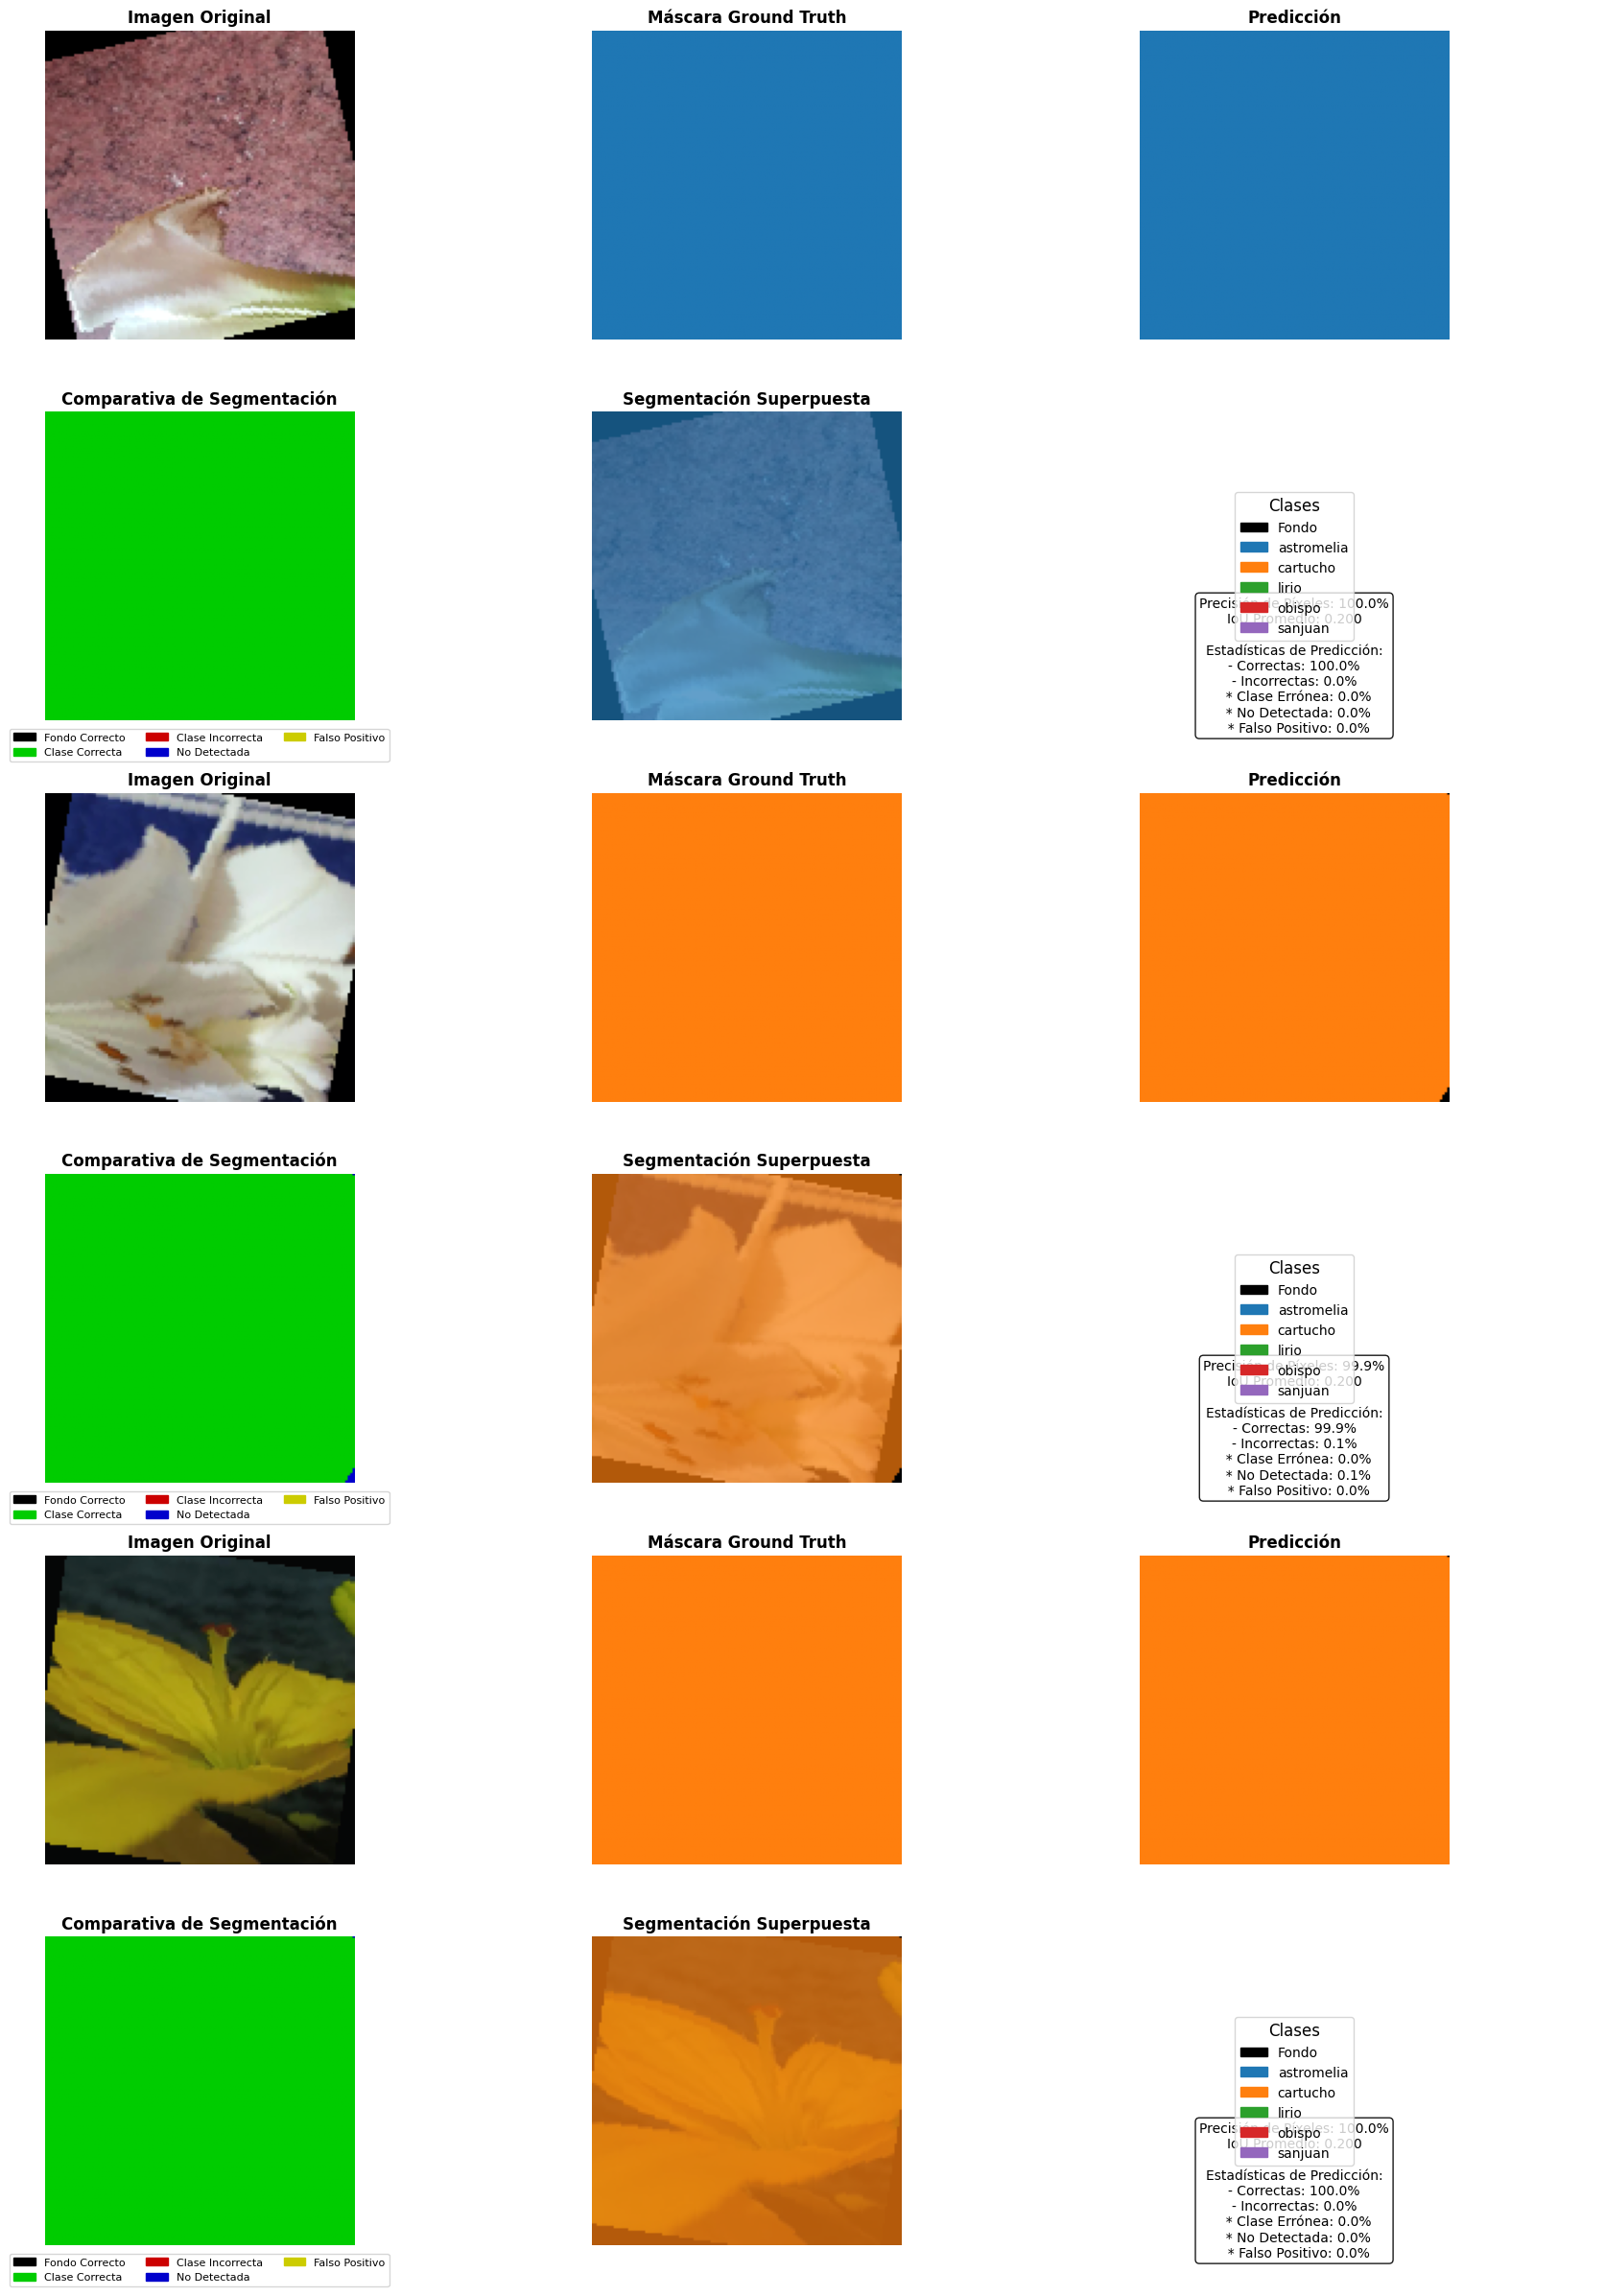

Visualización detallada de segmentación completada exitosamente.


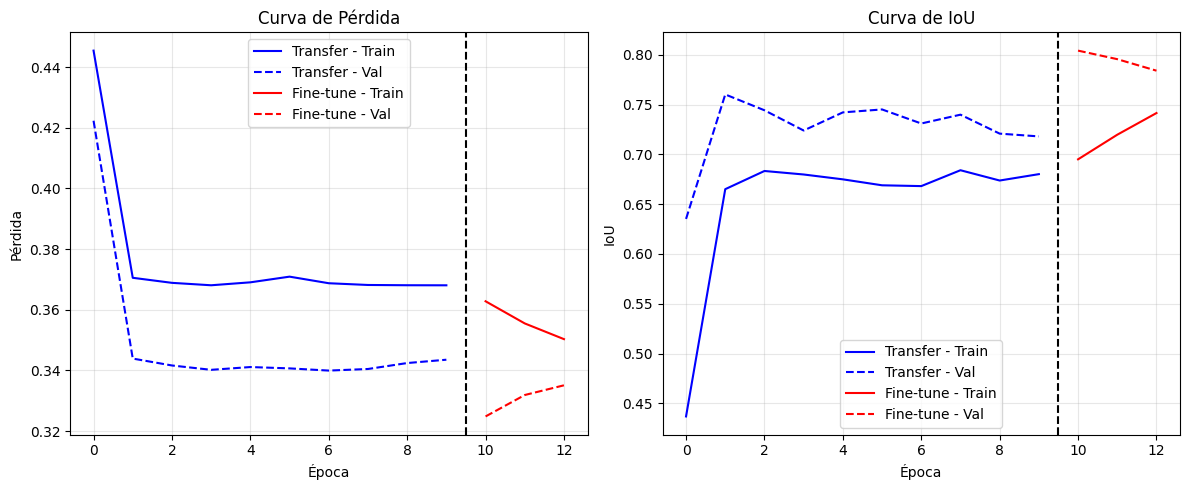


=== ENTRENAMIENTO COMPLETO FINALIZADO ===
Mejor modelo guardado como 'best_model_finetune.pth'
IoU final en test: 0.7980
Generando visualización detallada de segmentación y máscaras...


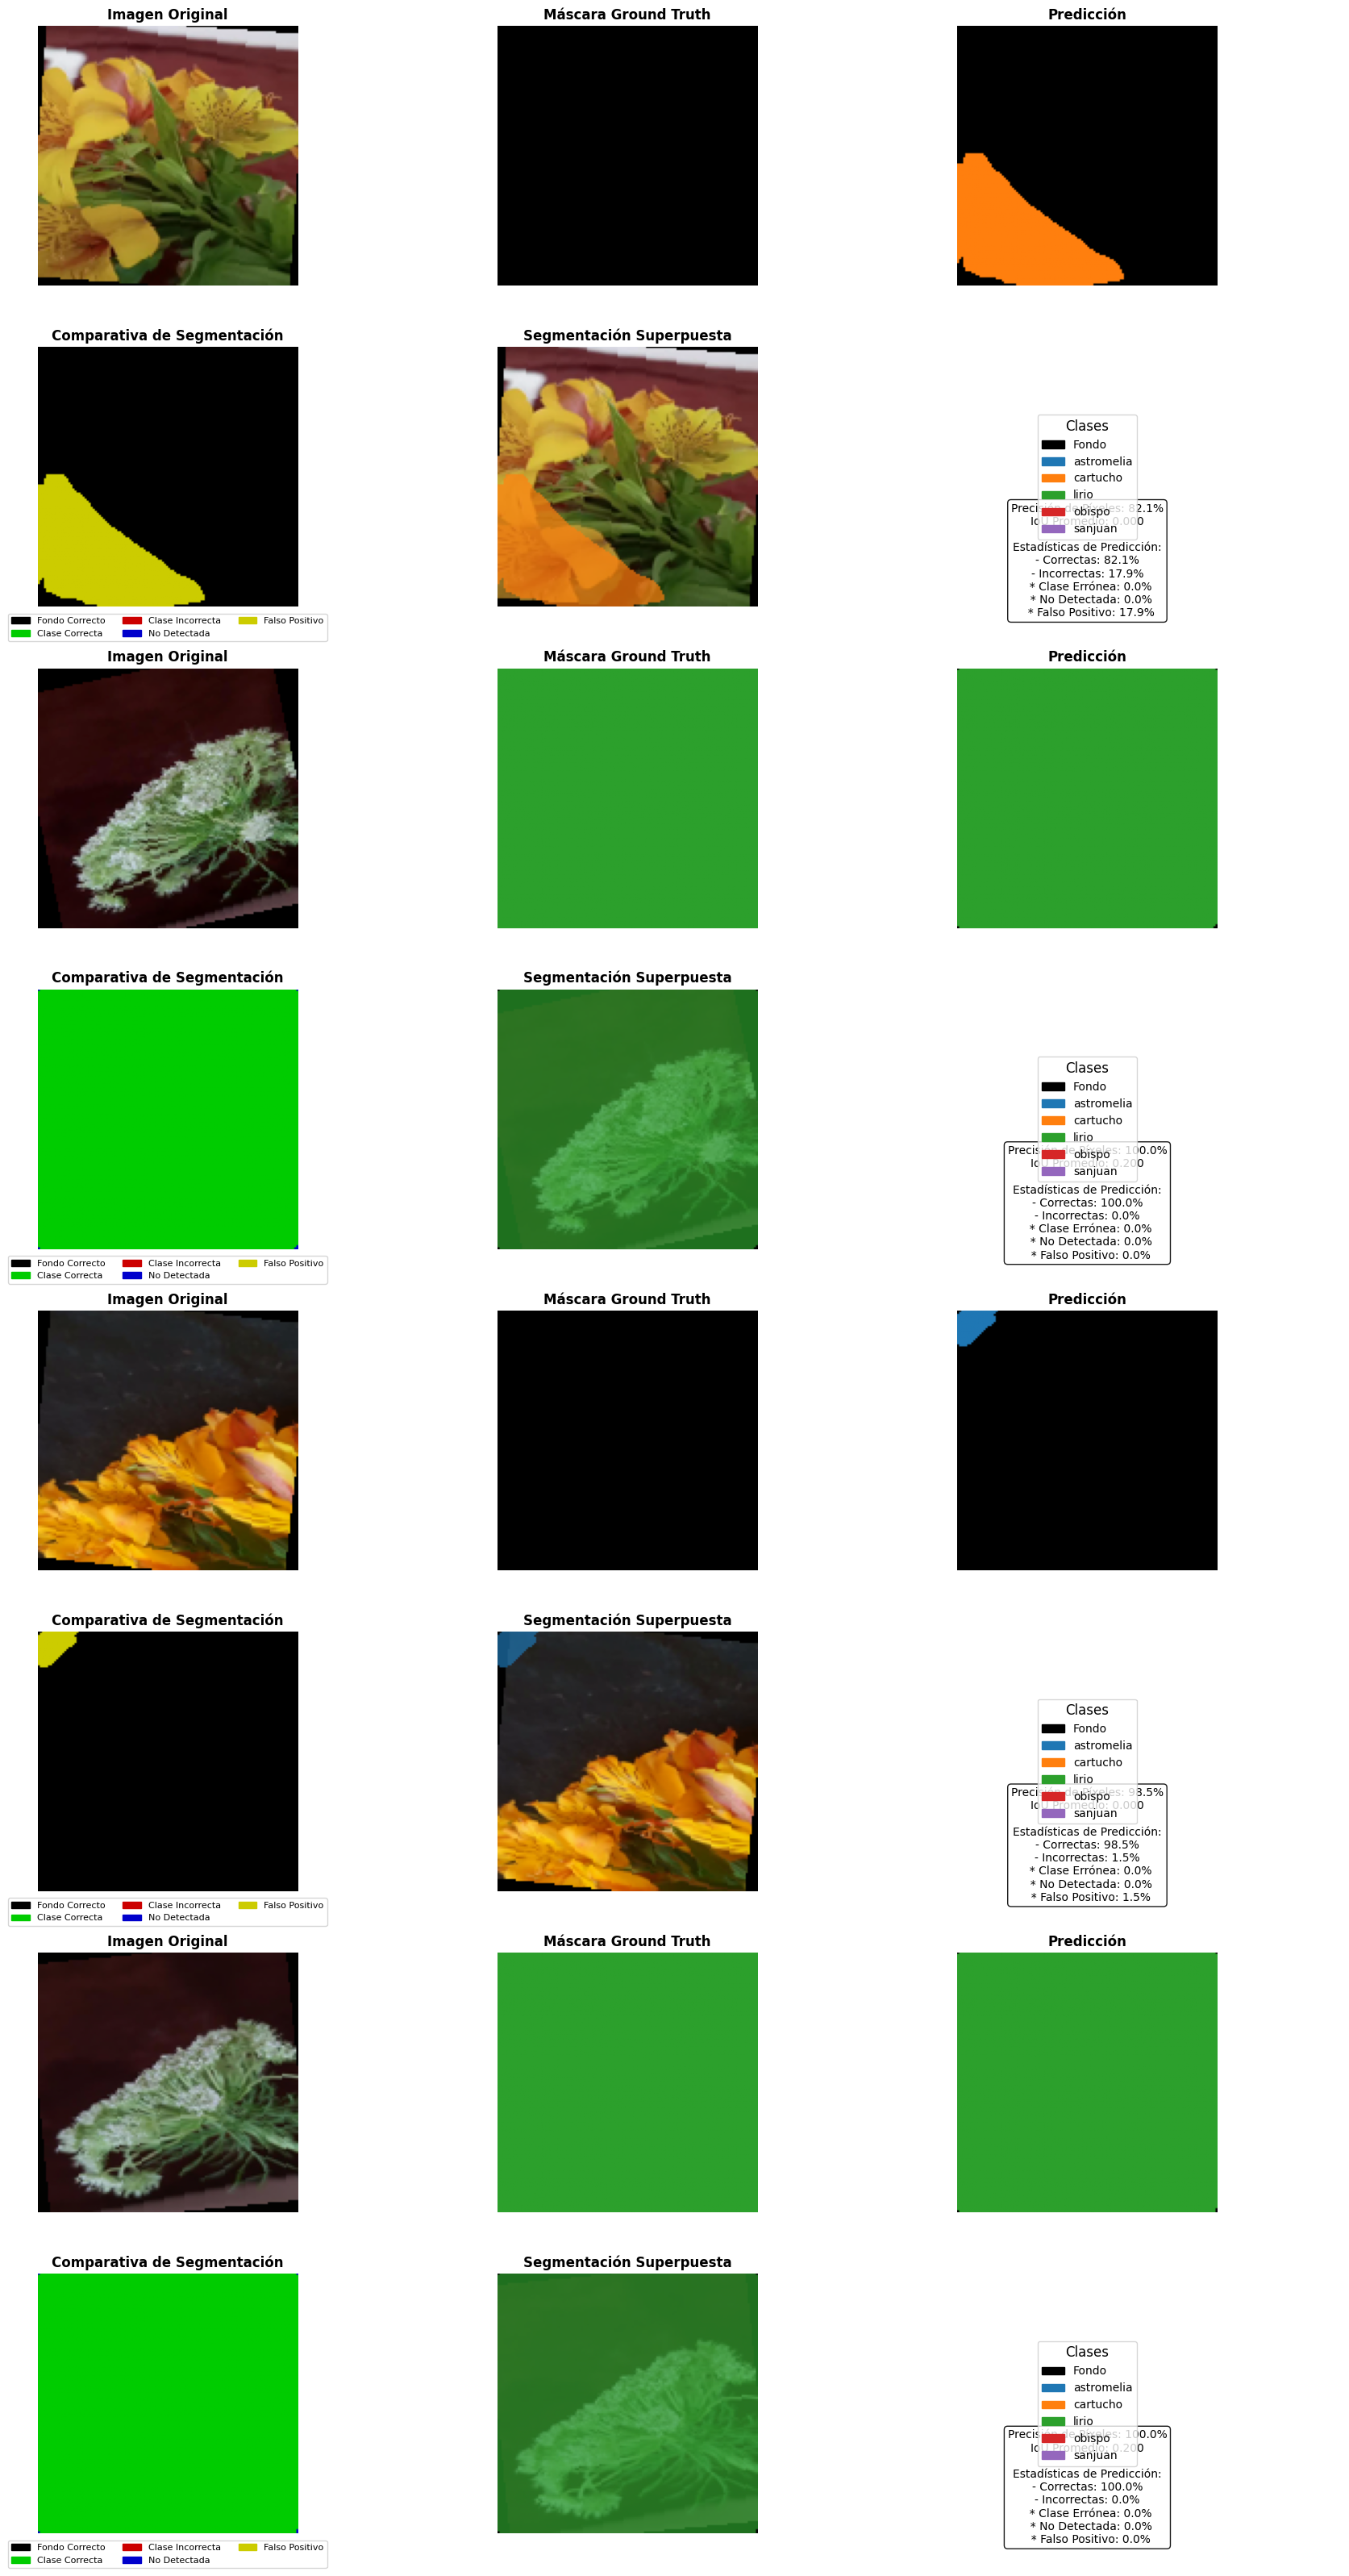

Visualización detallada de segmentación completada exitosamente.


In [261]:
if __name__ == "__main__":
    # Ejecutar el proceso completo de entrenamiento
    modelo_final = entrenar_modelo_completo(
        dataset_path='./Dataset-Flores',
        img_size=128,
        num_classes=5
    )
    
    # Si solo quieres ejecutar una visualización con el modelo final
    if modelo_final is not None:
        visualizar_segmentacion_detallada(modelo_final, test_dataset, num_samples=4)
    else:
        # Intentar cargar un modelo entrenado previamente
        try:
            modelo_cargado = DenseUNet(n_classes=5, pretrained=False)
            modelo_cargado.load_state_dict(torch.load('best_model_finetune.pth'))
            print("Modelo cargado desde 'best_model_finetune.pth'")
            
            # Cargar dataset_info para obtener test_dataset
            with open('dataset_info.pkl', 'rb') as f:
                dataset_info = pickle.load(f)
                test_dataset = dataset_info['test_dataset']
            
            visualizar_segmentacion_detallada(modelo_cargado, test_dataset, num_samples=4)
        except Exception as e:
            print(f"No se pudo cargar un modelo entrenado: {e}")